In [2]:
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns
import pandas as pd
import os
from collections import OrderedDict
import torch


In [1]:
input_data = os.path.join('/raw_data/Provo_Corpus.tsv')

In [3]:
predict_norms = pd.read_csv(input_data, sep='\t')
paragraphs = predict_norms.groupby('Text_ID')['Text'].max()

In [4]:
def preprocess_provo_corpus(input_data):
    """Reading the raw Provo Corpus dataset and create a dictionary with all useful 
    information we might need from it"""
    predict_norms = pd.read_csv(input_data, sep='\t')
    paragraphs = predict_norms.groupby('Text_ID')['Text'].max()
    
    paragraphs_provo = {}
    count = 0
    for text_id in range(1,56): #iterate over all provo paragraphs
        for word_num in predict_norms[predict_norms['Text_ID'] == text_id]['Word_Number'].unique(): #iterating over all words in each text
            word_dist = predict_norms[(predict_norms['Text_ID'] == text_id) & (predict_norms['Word_Number'] == word_num)]
            unique_human_words = word_dist['Response'].unique() #all human answered words for each word
            unique_word_dist = []
            for word in unique_human_words:
                unique_word_count = sum(word_dist[word_dist['Response'] == word]['Response_Count']) #getting all counts of the unique word and summing them
                unique_word_dist.append((word, unique_word_count))
            
            remove_noise = [item for item in unique_word_dist]# if item[1] != 1]
            word_dist_dict = dict(remove_noise)
            paragraphs_provo[count] = {}
            paragraphs_provo[count]['human_dist_over_next_word_pred'] = word_dist_dict 
            paragraphs_provo[count]['context_with_cloze_word'] = paragraphs[text_id].split(' ')[:int(word_num)]
            paragraphs_provo[count]['original_positioning'] = {'text_id':text_id, 'word_num':word_num}
            #store the distribution dictionary in a dictionary for each text word (and their position in the text - in case of duplicate words) 

            count = count + 1  

    return paragraphs_provo


In [5]:
paragraphs_provo = preprocess_provo_corpus(input_data)

In [6]:
def model_unbiased(data_per_context):
    #Check for failed to generate full-word samples and remove those
    fail = [d for d in data_per_context['ancestral_samples'] if d['pred'] == 'Failed to generate word']
    if len(fail) > 0:
        data_per_context['ancestral_samples'] = [x for x in data_per_context['ancestral_samples'] if x != 'Failed to generate word']
        
    #remove duplicates (from lowercasing)
    support_model = [x['pred'].lower() for x in data_per_context['ancestral_samples']]
    counts_model = [x['count'] for x in data_per_context['ancestral_samples']]
    dist = [[support_model[i], counts_model[i]] for i in range(len(counts_model))]
    words = set(map(lambda x:x[0], dist))
    merged_list = [[y[1] for y in dist if y[0]==x] for x in words]
    merged_counts = [sum(x) for x in merged_list]
    probs = [x/sum(merged_counts) for x in merged_counts]

    dist_model = [(list(words)[i], probs[i]) for i in range(len(list(words)))]
    #sort by highest probability
    dist_model.sort(reverse=True, key=lambda a: a[1])
    top_15_model = dist_model[:15]
    support_unbiased_model = [x[0] for x in top_15_model]
    probs_unbiased_model = [x[1] for x in top_15_model]

    return support_unbiased_model, probs_unbiased_model

In [17]:
def human_and_model_dist(word_num, text, data, model):
    context = data[text][word_num]['context']['text']
    
    support_human = [x['pred'].lower() for x in data[text][word_num]['human']]
    counts_human = [x['count'] for x in data[text][word_num]['human']]
    counts_human = [x / sum(counts_human) for x in counts_human]
    dist_human = [(support_human[i], counts_human[i]) for i in range(len(counts_human))]
    #sort by highest probability
    dist_human.sort(reverse=True, key=lambda a: a[1])
    top_15_human = dist_human[:15]
    support_original_human = [x[0] for x in top_15_human]
    probs_original_human = [x[1] for x in top_15_human]
    prob_mass_human = sum(probs_original_human)
    
    if model == 'unbiased':
        support_model, probs_model = model_unbiased(data[text][word_num])
        prob_mass_unbiased = sum(probs_model)
    
    print('Context: ' + context + ' (Length: ' + str(int(word_num) - 1) + ')')
    print('human probability mass shown', prob_mass_human)
    print('model probability mass shown', prob_mass_unbiased)

    
    plt.rc('font', size=40)# controls default text sizes

    fig, ax = plt.subplots(figsize=(20, 10))
    ax.bar(support_original_human, probs_original_human, alpha=0.5, label = 'Human Distribution (Prob. mass shown:' + "{:.2f}".format(prob_mass_human) + ')', color = 'orangered', hatch='//')
    ax.bar(support_model, probs_model, alpha=0.5, label = 'Model Distribution (Prob. mass shown:' + "{:.2f}".format(prob_mass_unbiased) + ')', color = 'dodgerblue', hatch = '.')
    ax.legend(loc=1, prop={'size': 35})

    ax.set_xlabel('Word', fontsize=40)
    ax.set_ylabel('Probability', fontsize=40)
    # ax.set_title('Context: ' + context, size = 40,fontweight="bold")
    ax.tick_params(axis = 'x',labelrotation=90)    

    # plt.savefig('dists_' + str(word_num) + 'specific.pdf', format="pdf",bbox_inches='tight') #dpi=300, 
    plt.show()


In [15]:
#Open the file with the passage you are interested to visualise
f = open('/TVD/GPT2/Generations/Paragraphs-4-4.json')

data = json.load(f)

f.close()

Context: Liza was in a bad temper, for she was mixing the Christmas puddings in the kitchen, and had been drawn (Length: 20)
human probability mass shown 1.0
model probability mass shown 0.8700000000000002


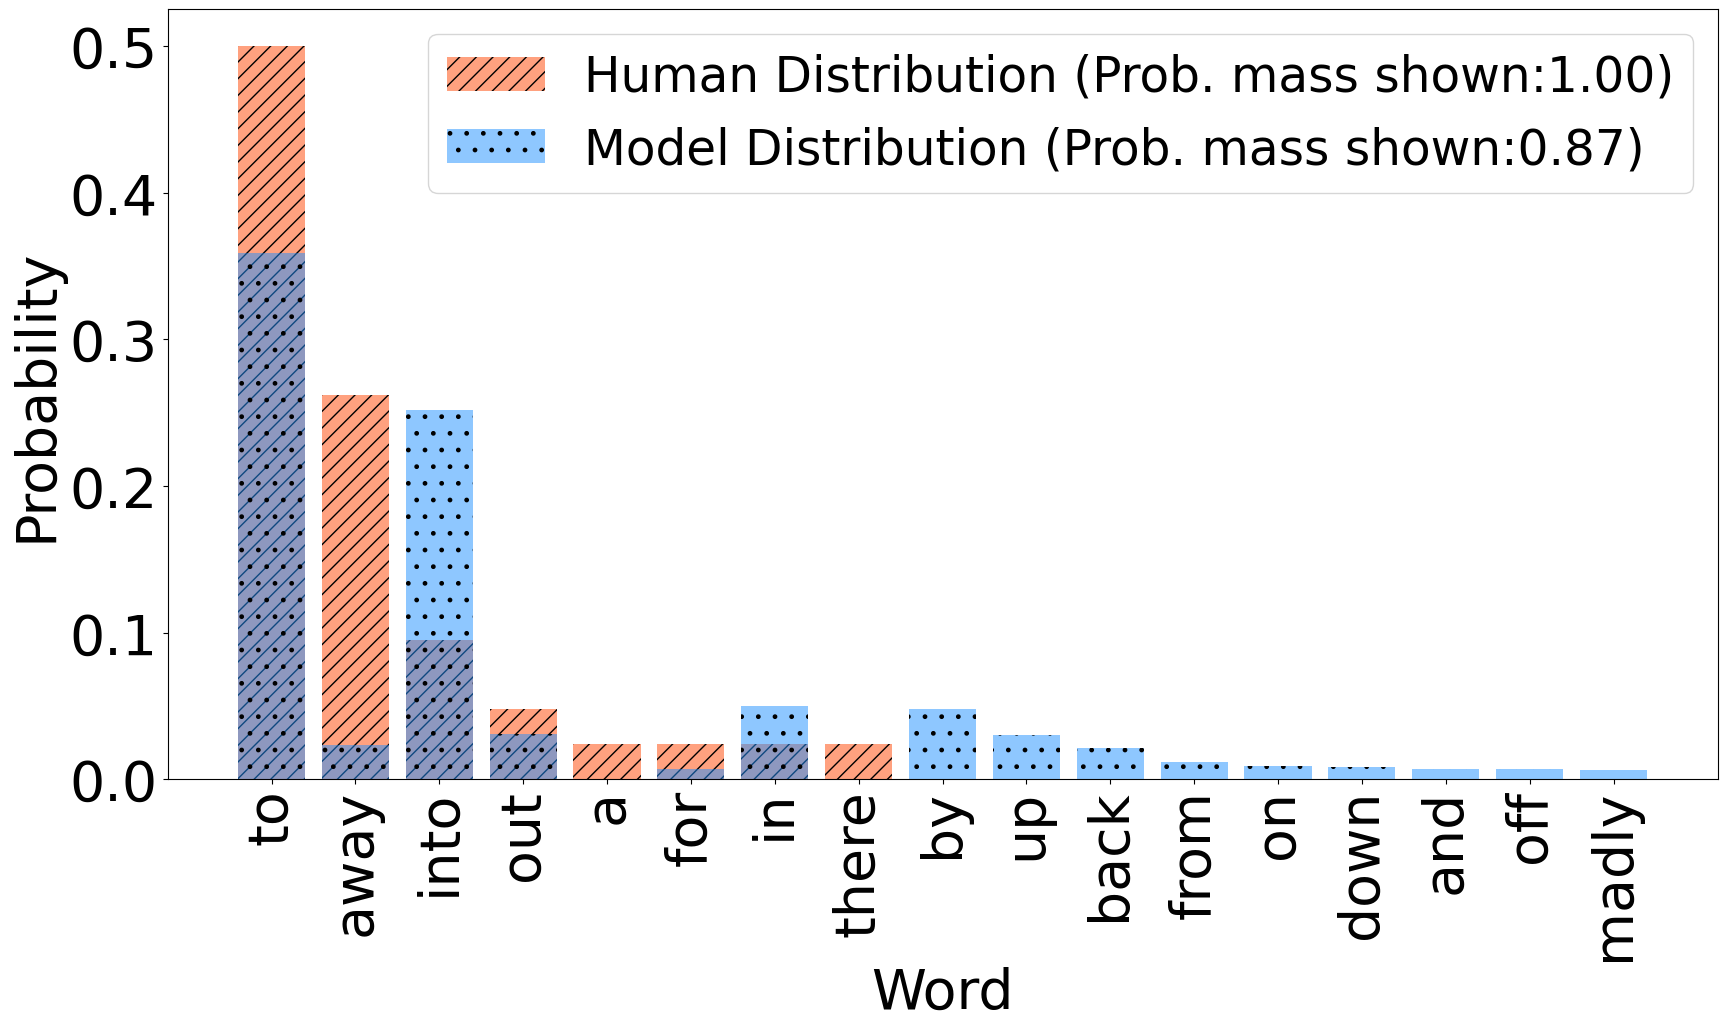

In [16]:
#Give the passage number and the word number (from 2 - (length of passage - 1))
text = '4'
word_num = '21'
human_and_model_dist(word_num, text, data, 'unbiased')

Context: Liza (Length: 1)
human probability mass shown 0.9285714285714288
model probability mass shown 0.18500000000000005


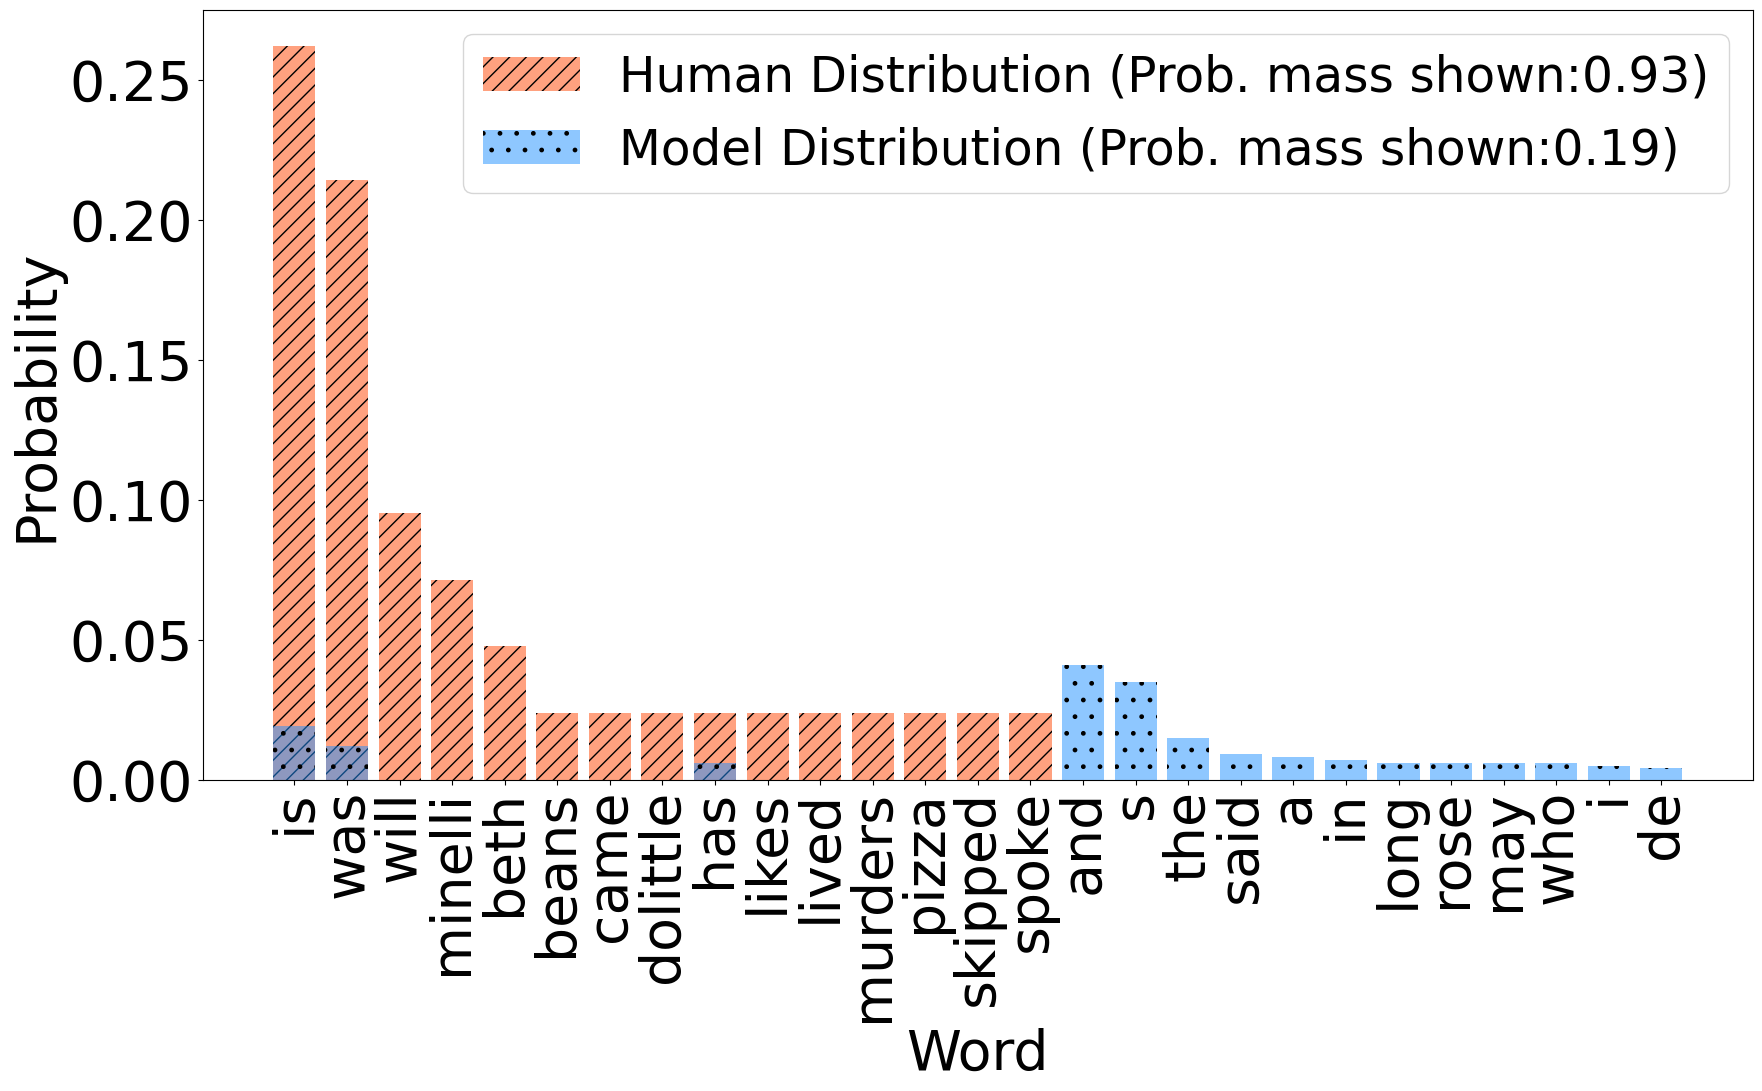

Context: Liza was (Length: 2)
human probability mass shown 0.7619047619047621
model probability mass shown 0.29500000000000004


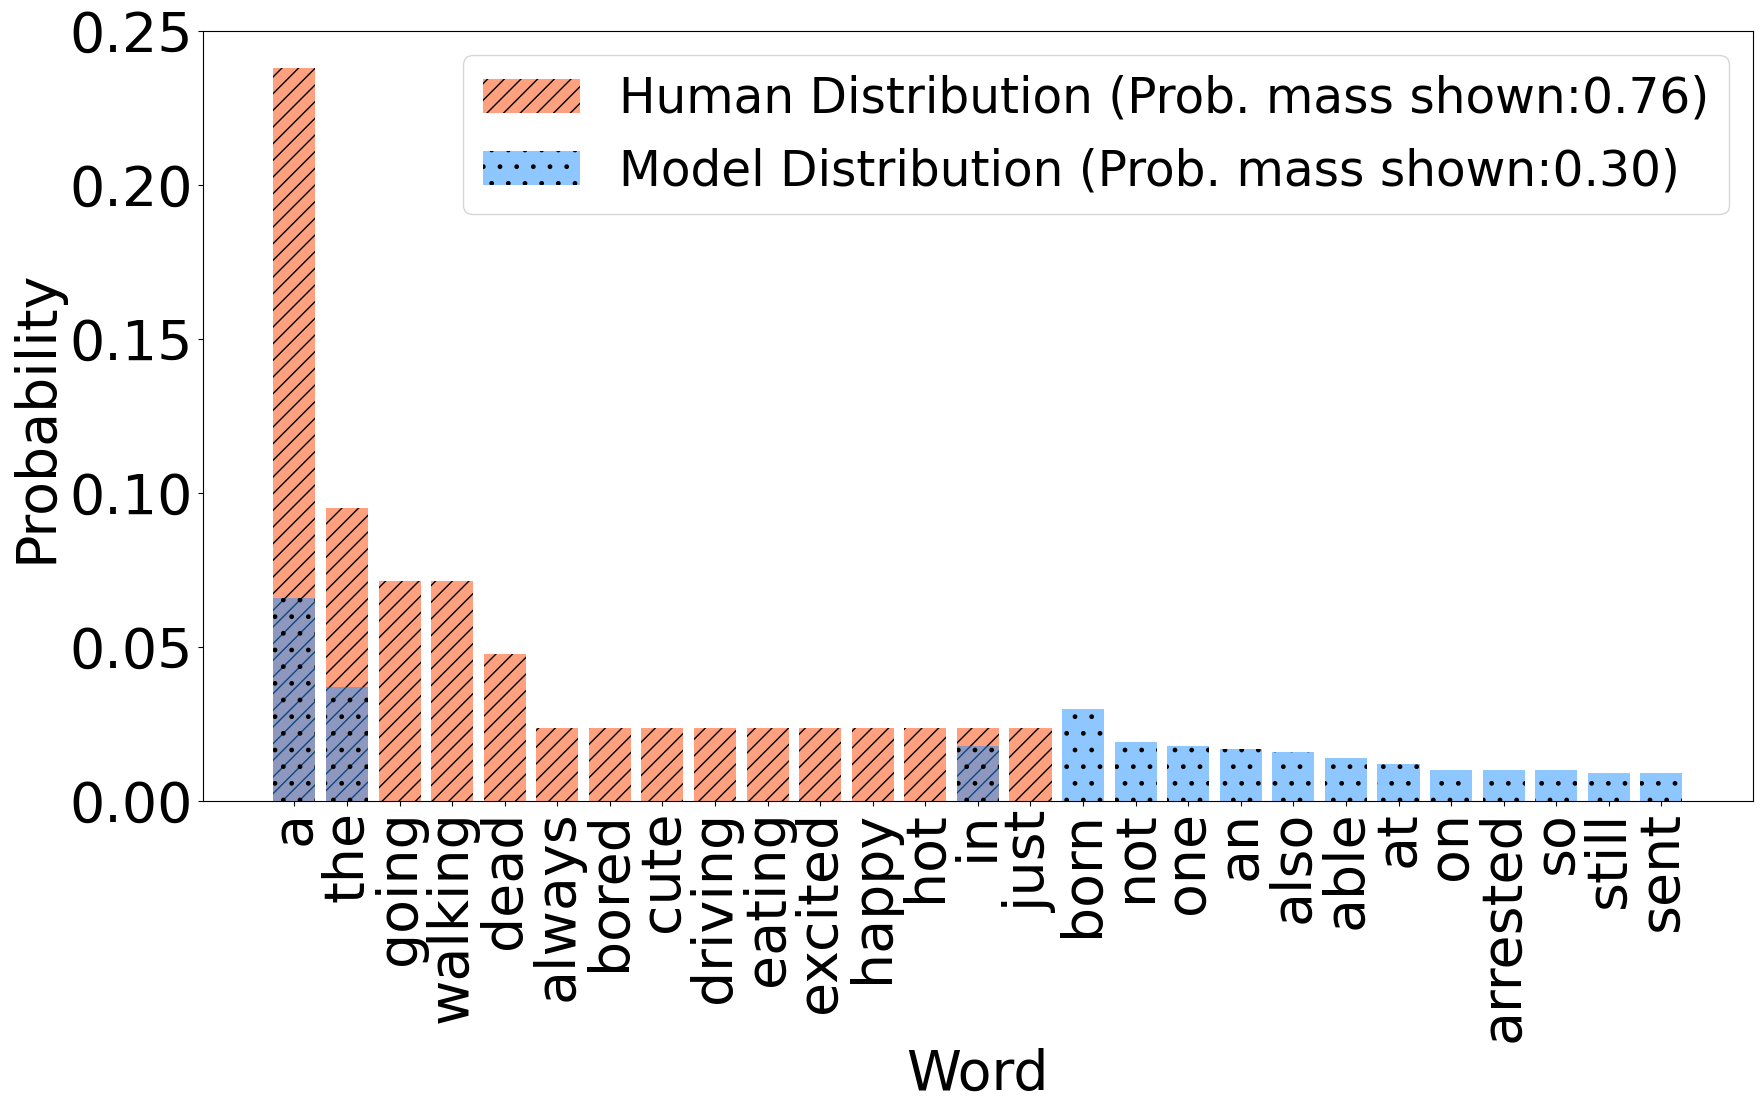

Context: Liza was in (Length: 3)
human probability mass shown 0.9523809523809527
model probability mass shown 0.5110000000000001


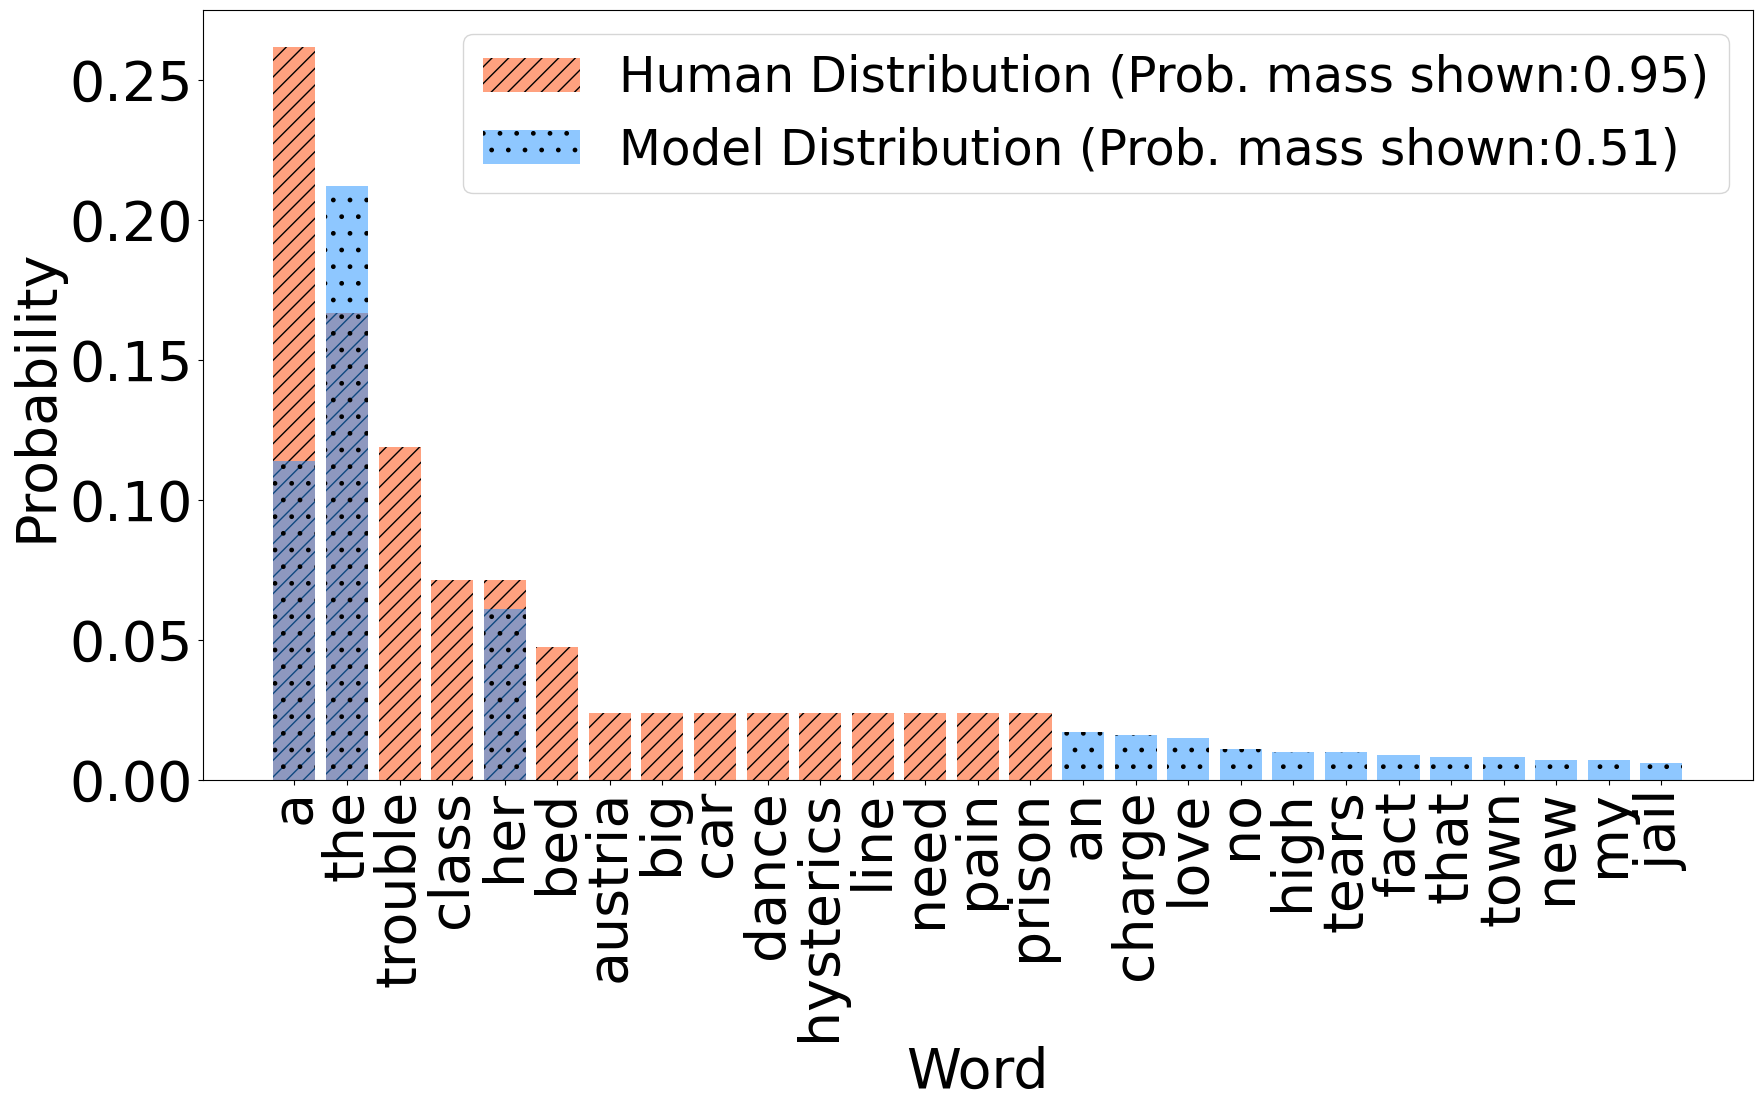

Context: Liza was in a (Length: 4)
human probability mass shown 0.7142857142857145
model probability mass shown 0.2730000000000001


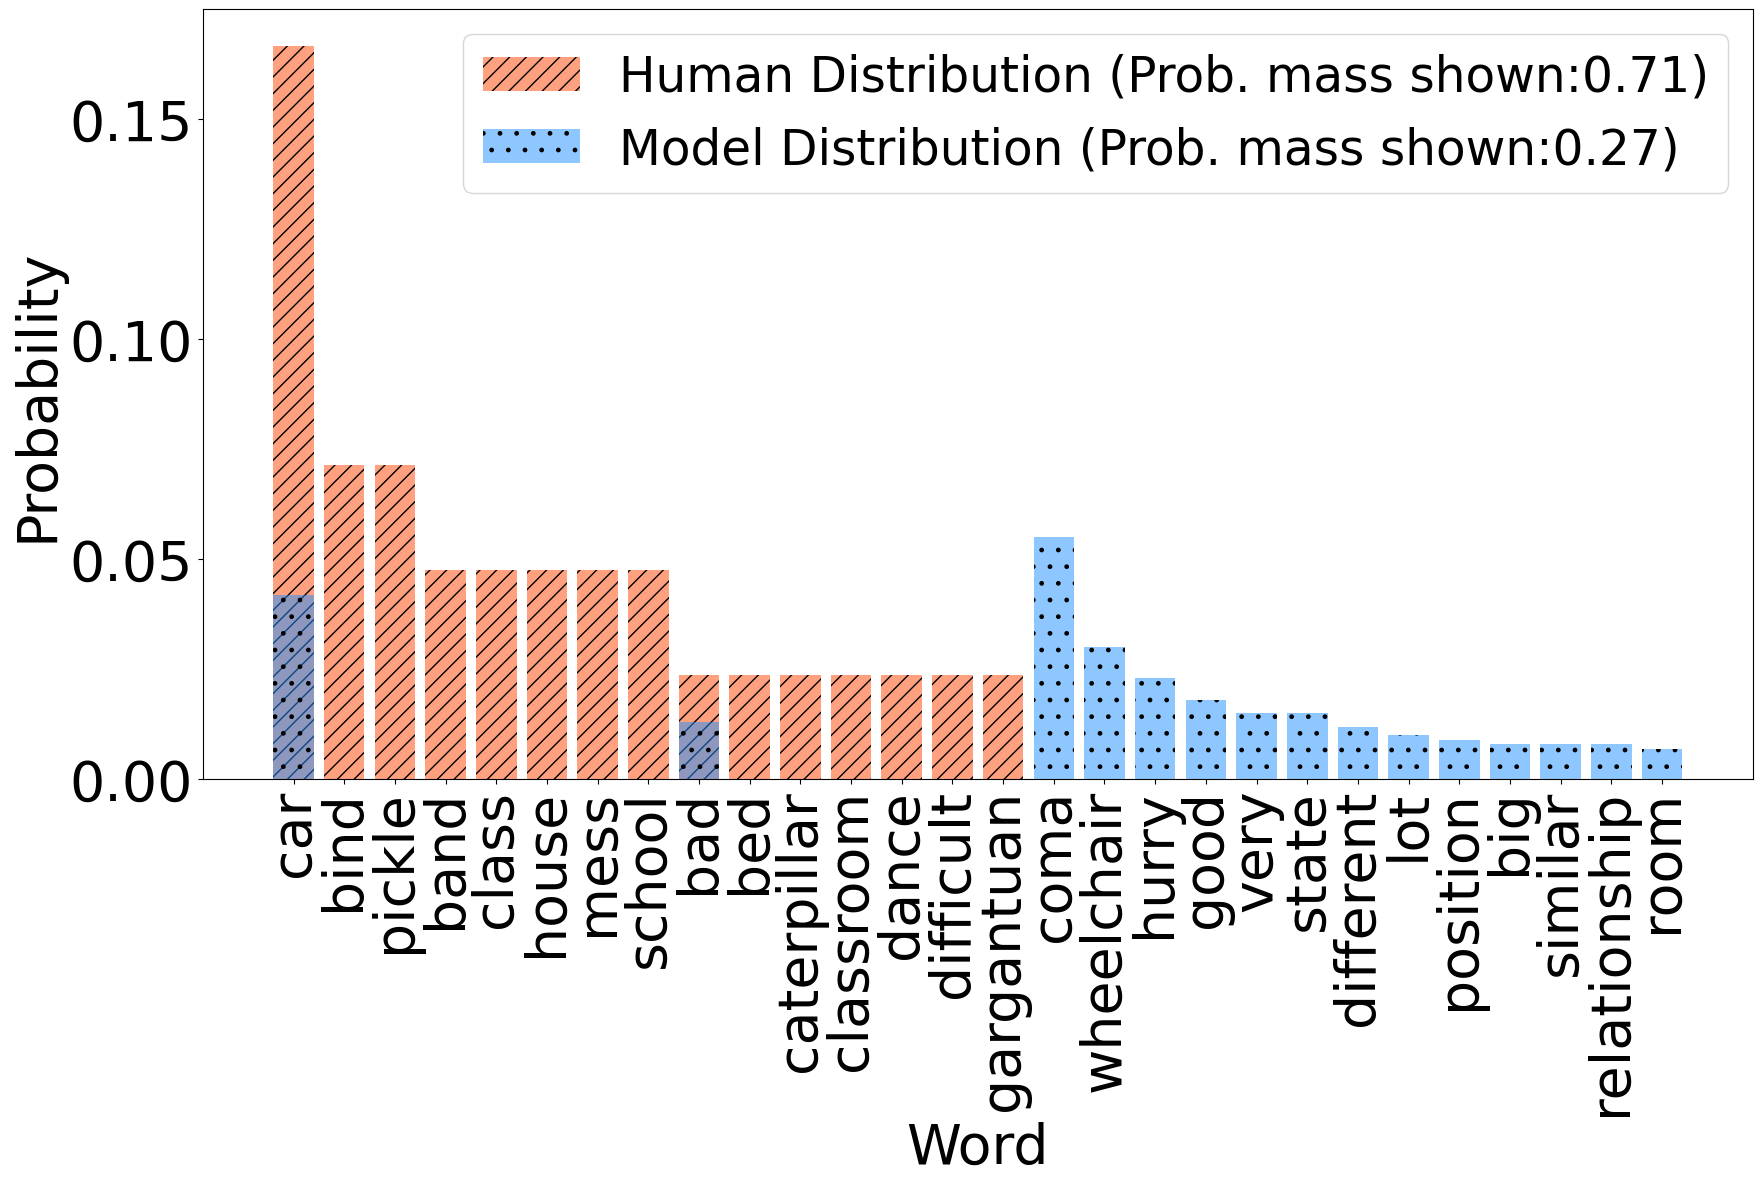

Context: Liza was in a bad (Length: 5)
human probability mass shown 1.0
model probability mass shown 0.8820000000000001


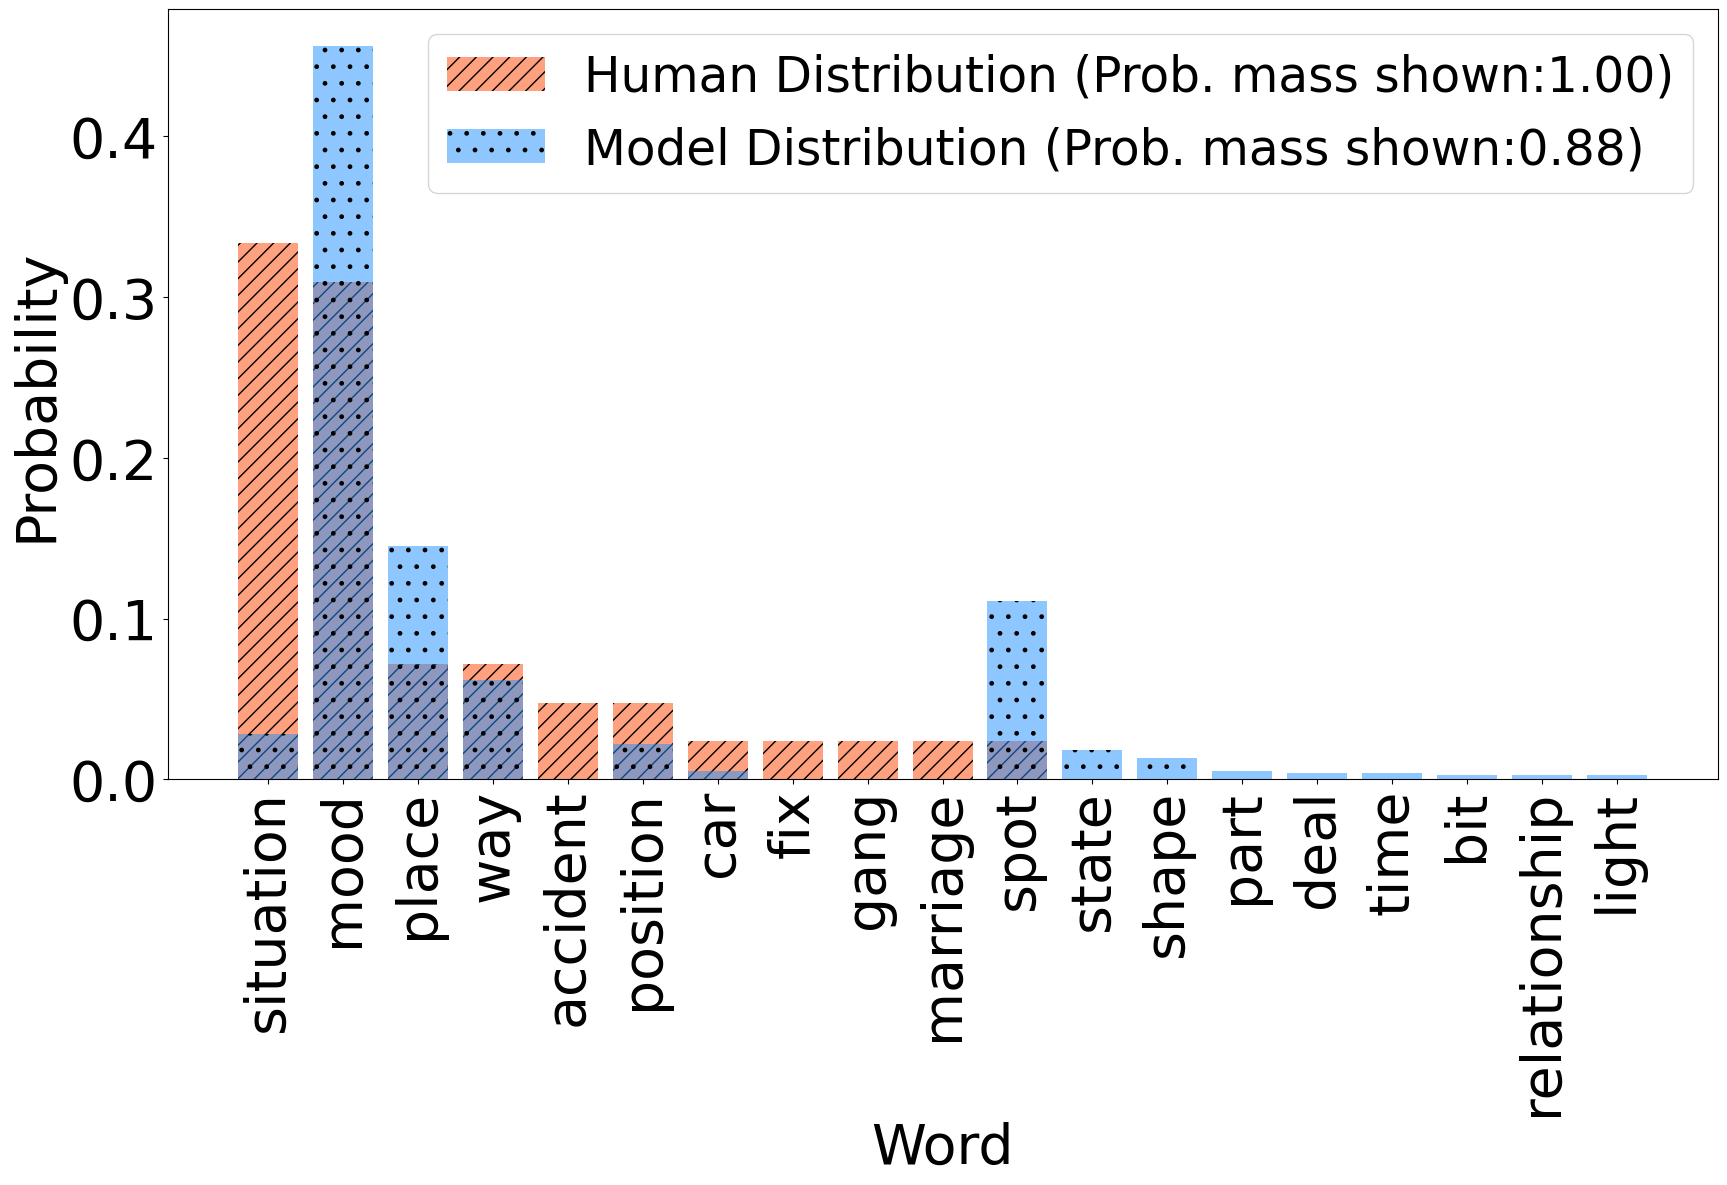

Context: Liza was in a bad temper, (Length: 6)
human probability mass shown 1.0
model probability mass shown 0.6170000000000001


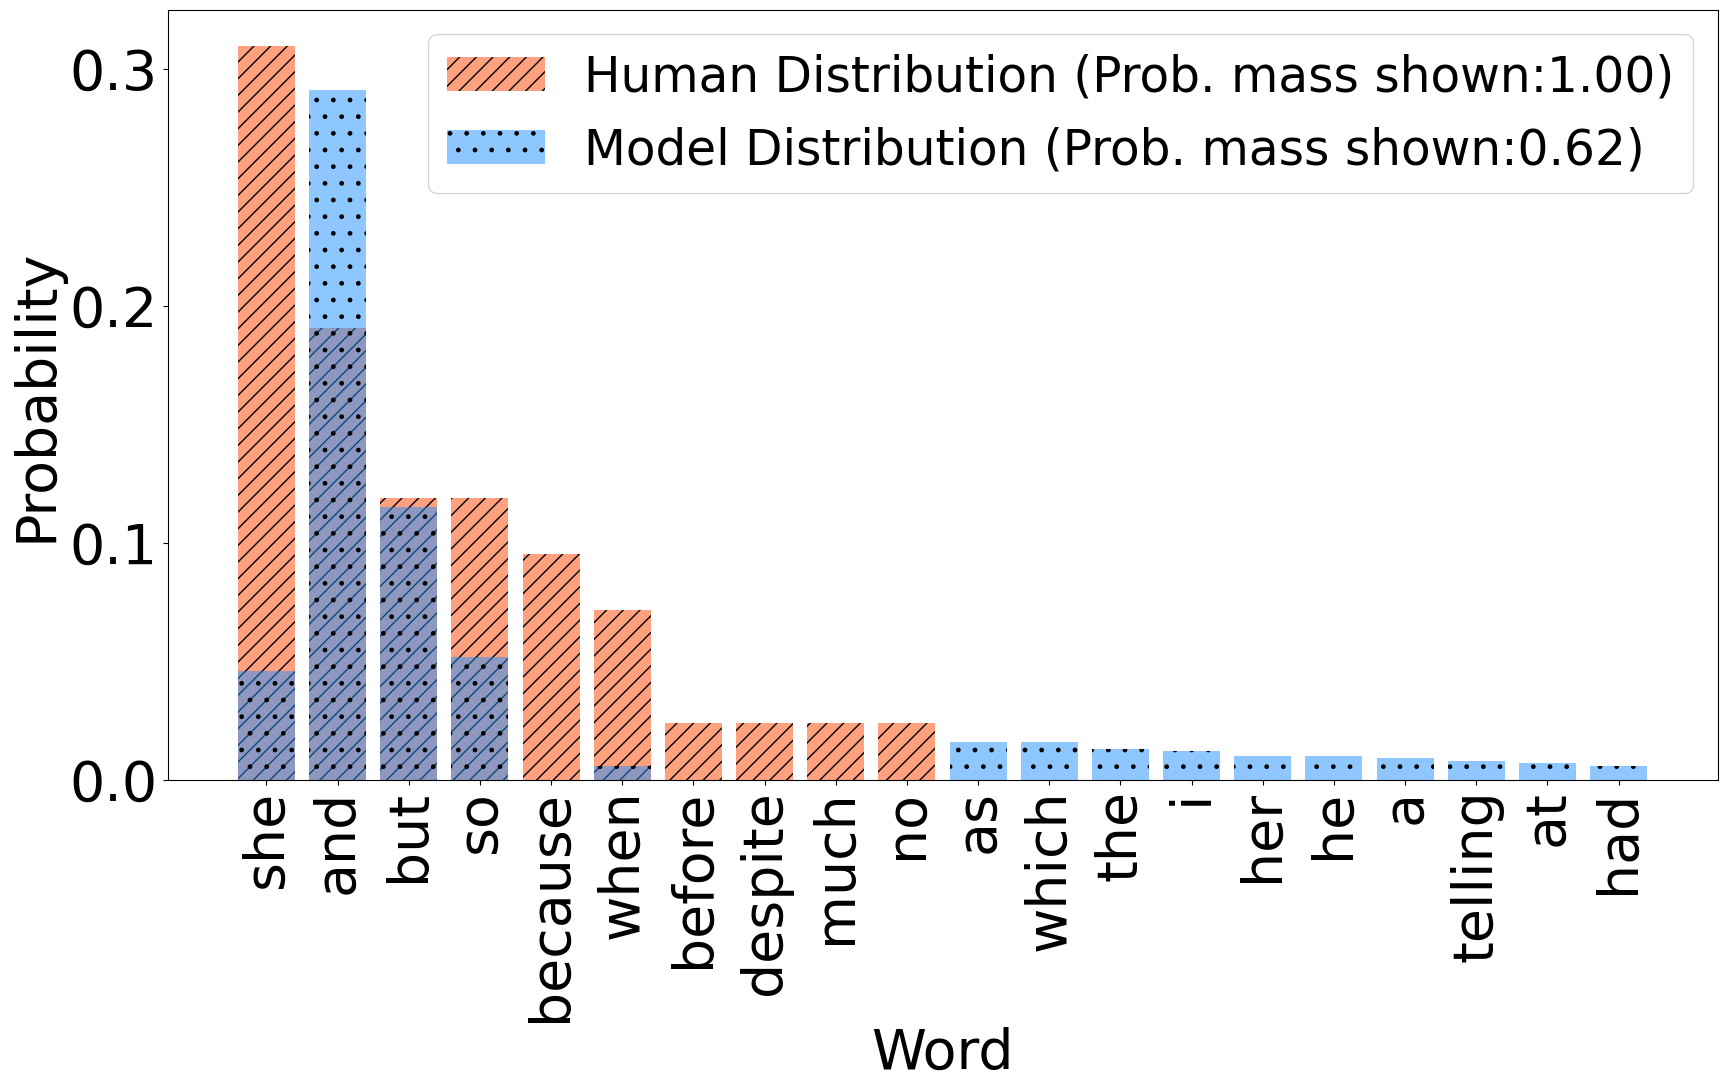

Context: Liza was in a bad temper, for (Length: 7)
human probability mass shown 0.9761904761904763
model probability mass shown 0.6020000000000002


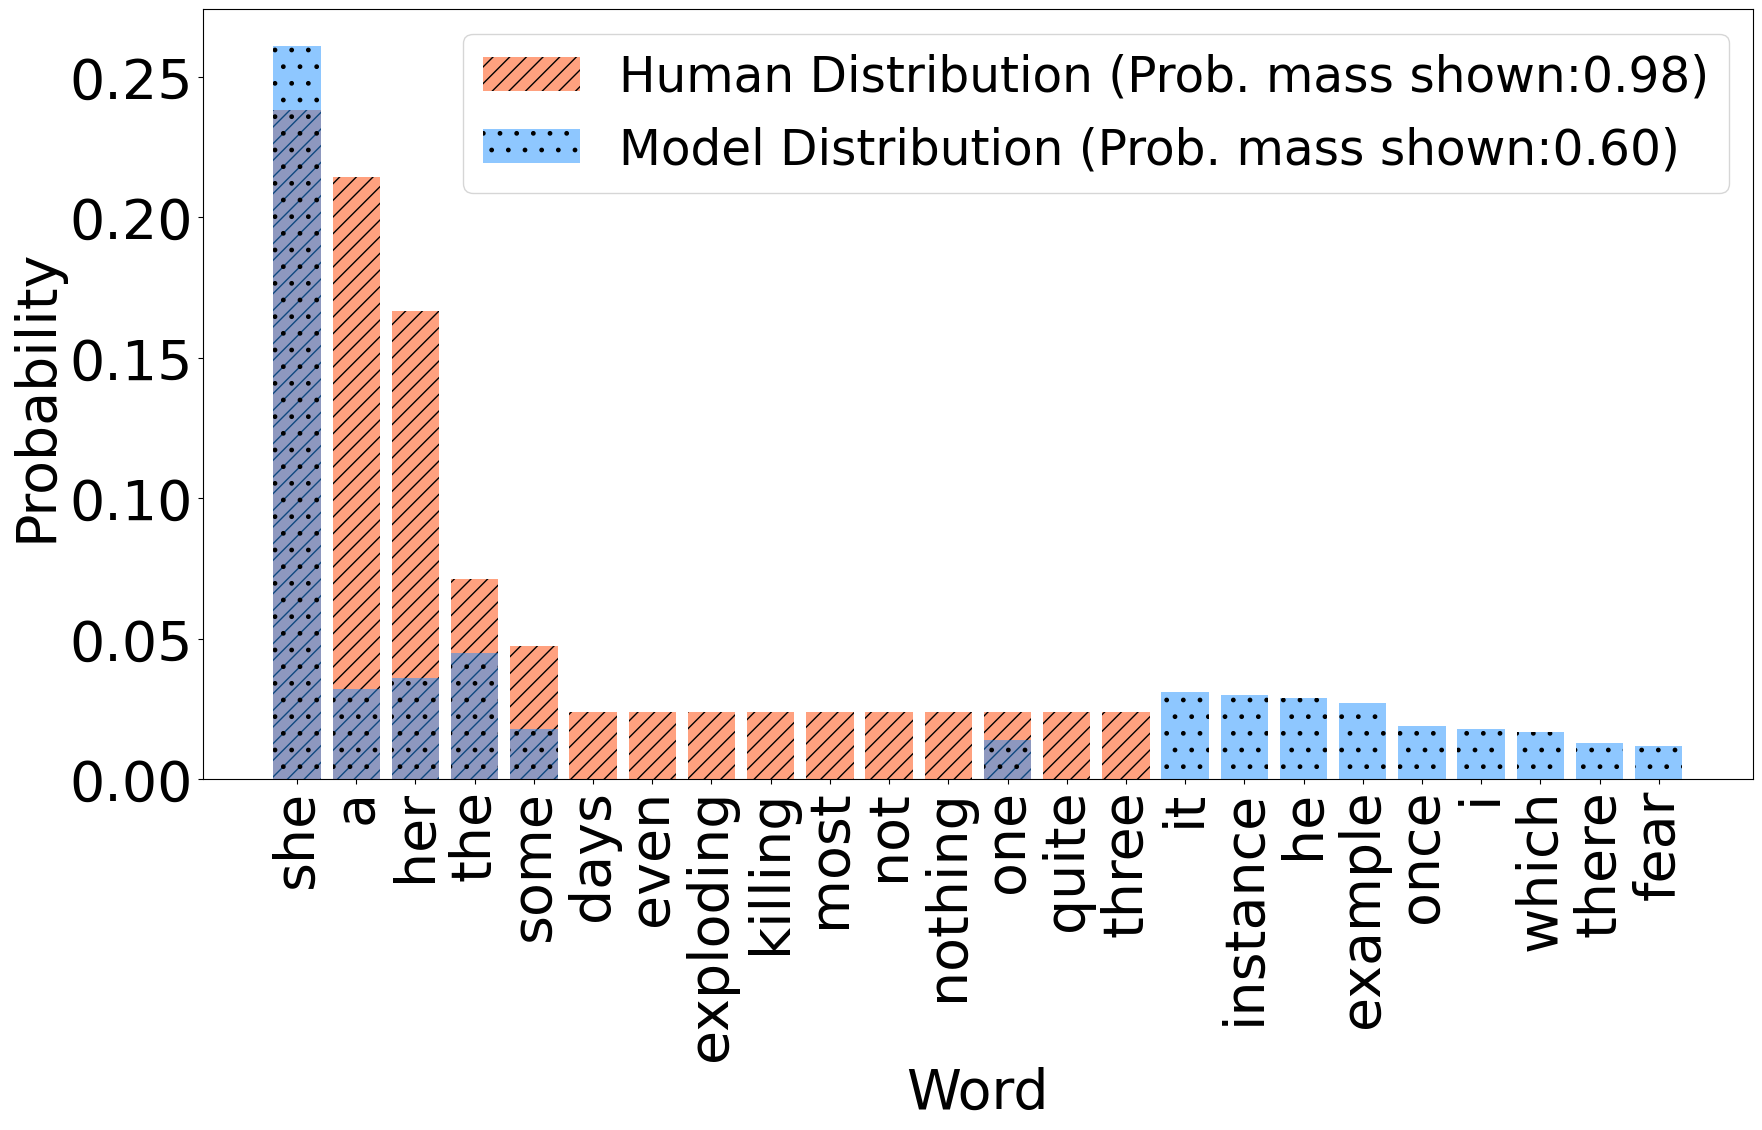

Context: Liza was in a bad temper, for she (Length: 8)
human probability mass shown 1.0000000000000002
model probability mass shown 0.5730000000000002


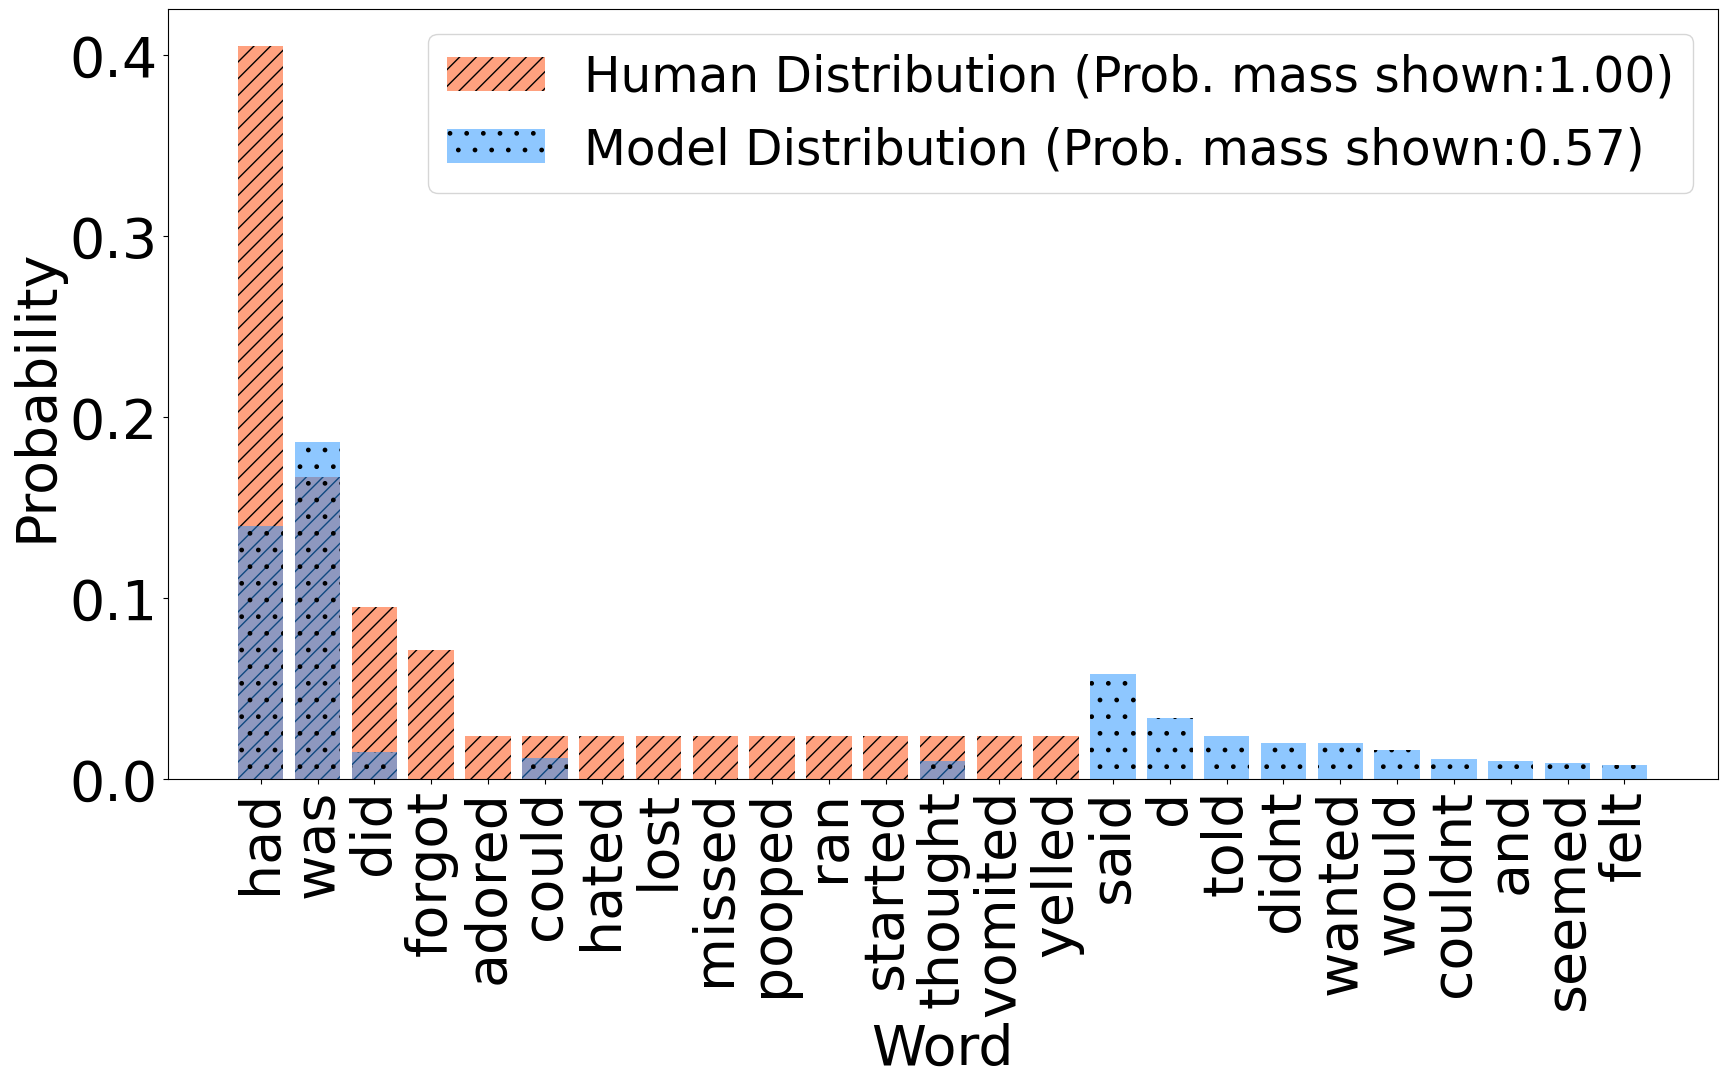

In [19]:
# You can also get it for multiple consecutive contexts 
# os.path.join(os.getcwd(), 'dists')
text = '4'
for i in range(2, 10): #(2,58)
    word_num = str(i)
    human_and_model_dist(word_num, text, data, 'unbiased')